In [1]:
import pickle
import bson
import pandas as pd
import pandas as pd
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns


pd.set_option('display.max_columns', None)

In [2]:
merged_df_with_3P = pd.read_csv('../../../processed_data/merged_df_with_3P.csv')

In [51]:
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

X = merged_df_with_3P.drop([
    'game_id', 'team_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id', 'date', 
    'has_locations', 'has_segments', 'team1', 'team2', 'hometeam', 'Made', 'Time', 'Stat', 'season', 
    'league', 'score','winning_team','Fastbreak',
    'score_opp', 'And1', 'Blocked', 'Assisted', 'Unnamed: 0'
], axis=1)

X = clean_column_names(X)

categorical_features = ['Location', 'Zone','Period','LBA_position', 'year', 'Shot_type'] 

# Convert the columns to 'category' type
for col in categorical_features:
    if col in X.columns:  # Check if the column exists in the DataFrame
        X[col] = X[col].astype('category')

# Use 'Made' as the target variable
y = merged_df_with_3P['Made']

In [9]:
better_players = pd.read_pickle('../../../processed_data/Players_that_shot_at_least_45perc_on_120_or_more_3PA.pickle').to_list()
better_players = [str(i) for i in better_players]
better_players

['61929104291cd446e954254f',
 '6192aac173c0a0725fd800d9',
 '6192aac173c0a0725fd800da',
 '61a7dd3d4ae6ee62b7246c32',
 '618da04c4db298feb94bc215',
 '618ff082d1901c632789ff40',
 '619295ef6e99de05cc323457',
 '61aa93965e9ccfe1aca905a0',
 '6192b6c6399ba647d1f4c287',
 '6192a4f8983d5433eb97fd4f',
 '61929bee26b7bf93bb71f6bd']

In [10]:
worse_players = pd.read_pickle('../../../processed_data/Players_that_shot_at_most_18perc_on_40_or_more_3PA.pickle').to_list()
worse_players = [str(i) for i in worse_players]
worse_players

['6192b749399ba647d1f4cb75',
 '636c3a1baf77c98d5eb1a33d',
 '61b90ac6ab12df69682f6cce',
 '636d880c1f186408f6c5f250',
 '618da0c64db298feb94bc69c',
 '620b0d7cd4af970dcb4a8d08',
 '636f9a2d27131d1edcac7f8e',
 '636d888d1f186408f6c621bd']

In [12]:
def get_transformed_X_y(sub_merged_df_with_3P,X,y):
    return X.iloc[sub_merged_df_with_3P.index],y.iloc[sub_merged_df_with_3P.index]

In [28]:
relevant_players = worse_players+better_players

In [31]:
ids_remove = merged_df_with_3P.loc[merged_df_with_3P.player_id.isin(relevant_players)].index

In [38]:
relevant_player_df = merged_df_with_3P.loc[merged_df_with_3P.player_id.isin(relevant_players)]
irrelevant_player_df = merged_df_with_3P.loc[~(merged_df_with_3P.player_id.isin(relevant_players))]
relevant_player_df.shape, irrelevant_player_df.shape, (relevant_player_df.shape[0]+irrelevant_player_df.shape[0]) ==merged_df_with_3P.shape[0]

((2119, 148), (259852, 148), True)

In [52]:
og_X,og_y = X.copy(),y.copy()

In [53]:
X,y = get_transformed_X_y(irrelevant_player_df,X,y)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 70502, number of negative: 137379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13010
[LightGBM] [Info] Number of data points in the train set: 207881, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339146 -> initscore=-0.667102
[LightGBM] [Info] Start training from score -0.667102


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

Train-------------------------------
Train Accuracy: 0.34905546923480263
Train Precision: 0.3421384628124132
Train Recall: 0.996283793367564
Train F1 Score: 0.5093564516187513
Train AUC ROC: 0.6025043939476775
Test-------------------------------
Test Accuracy: 0.3483866002193531
Test Precision: 0.3429805951848031
Test Recall: 0.9939086294416244
Test F1 Score: 0.5099769928663416
Test AUC ROC: 0.5476503951380227
Optimum Threshold for Maximum F1 Score: 0.23


Text(0.5, 1.0, 'Feature Importance')

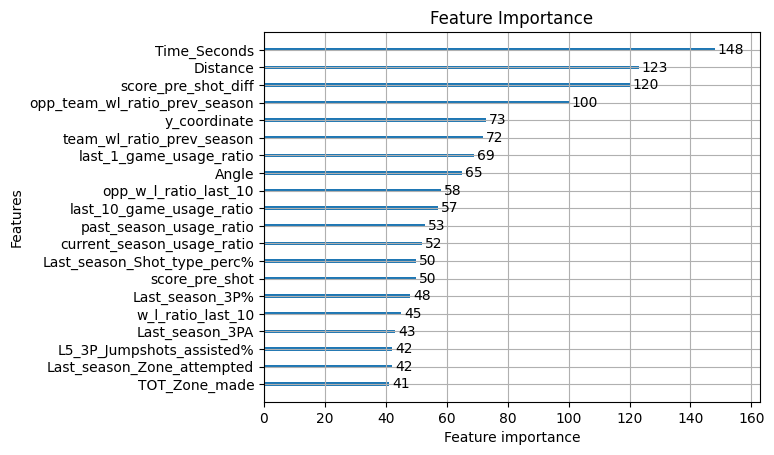

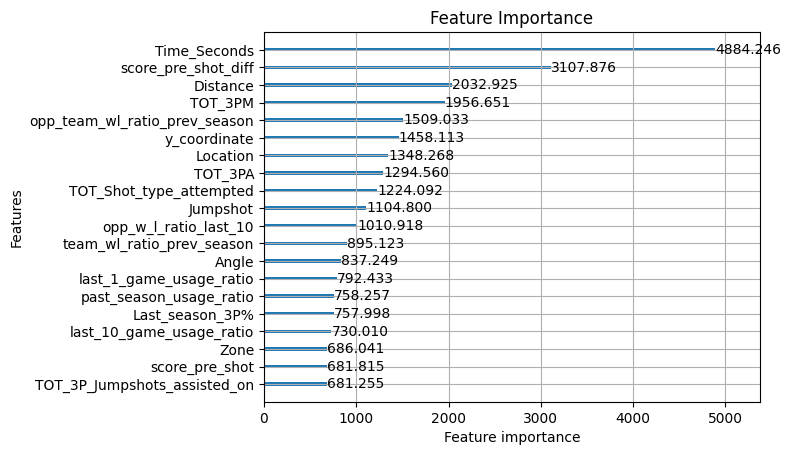

In [44]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [45]:
y_train_pred_3p = y_train_pred
best_threshold_3p = best_threshold
y_pred_3p = y_pred
y_train_3p = y_train
y_test_3p = y_test
X_3p = X

In [46]:
# Function to plot probabilities
def plot_probabilities(probs, title):
    sns.histplot(probs, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_combined_probabilities(prob_2p, prob_3p):
    weighted_2p = prob_2p * 2
    weighted_3p = prob_3p * 3
    return np.concatenate([weighted_2p, weighted_3p])

In [47]:
# Displaying the best thresholds
# print(f"Best threshold for 2-pointers: {best_threshold_2p}")
print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
# y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
# y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 3-pointers: 0.23


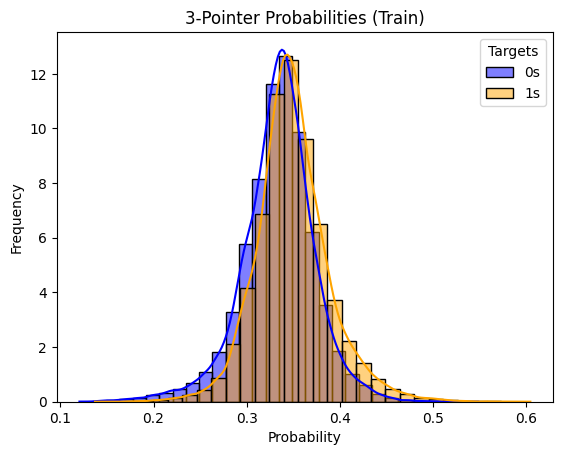

In [48]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

# y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
# y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

# plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

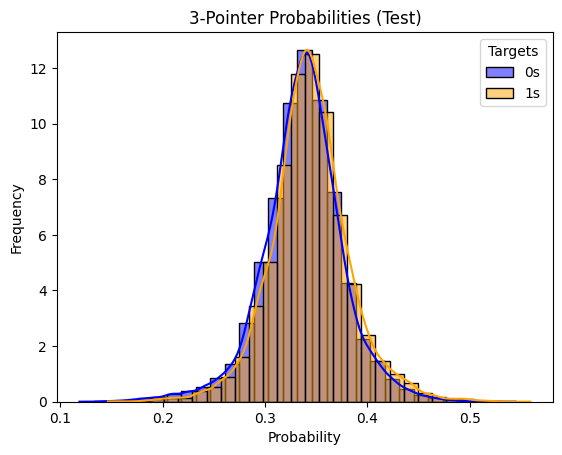

In [49]:
# y_test_pred_2p = np.array(y_pred_2p)
y_test_pred_3p = np.array(y_pred_3p)
# y_test_2p = np.array(y_test_2p)
y_test_3p = np.array(y_test_3p)

# y_test_2p = y_test_2p.reshape(-1)
y_test_3p = y_test_3p.reshape(-1)

# y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
# y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

# plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

In [55]:
X_bp,y_bp = get_transformed_X_y(merged_df_with_3P.loc[merged_df_with_3P['player_id'].isin(better_players)],og_X,og_y)
X_wp,y_wp = get_transformed_X_y(merged_df_with_3P.loc[merged_df_with_3P['player_id'].isin(worse_players)],og_X,og_y)
y_bp_pred = bst.predict(X_bp, num_iteration=bst.best_iteration)
y_wp_pred = bst.predict(X_wp, num_iteration=bst.best_iteration)

In [56]:
def plot_probabilities_compare(probs_a, probs_b, title):
    sns.histplot(probs_a, kde=True, color='blue', bins=30, label='prob_a', stat='density')
    sns.histplot(probs_b, kde=True, color='orange', bins=30, label='prob_b', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

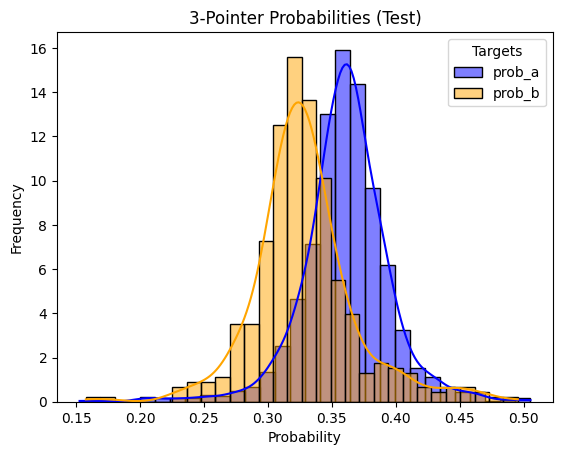

In [57]:
y_bp_pred = np.array(y_bp_pred)
y_wp_pred = np.array(y_wp_pred)

plot_probabilities_compare(y_bp_pred, y_wp_pred, '3-Pointer Probabilities (Test)')

#prob_a Players_that_shot_at_least_45perc_on_120_or_more_3PA
#prob_b Players_that_shot_at_most_18perc_on_40_or_more_3PA